# Task


1. **Web Scraping**: Utilize the website Skytrax to gather review data about the airline. You can use the provided Jupyter Notebook in the Resources section to execute Python code that will assist in data collection.

2. **Data Analysis**: Once you have your dataset, prepare it by cleaning the messy and text-heavy data. After cleaning, conduct your own analysis to uncover insights. You might consider sentiment analysis, topic modeling, or generating word clouds to gain insights into the content of the reviews. It's recommended to complete this task using Python, but you can use any tool of your choice. Utilize the documentation websites provided in the Resources section to analyze the data.

3. **Presenting Insights**: Create a single PowerPoint slide that summarizes your findings. Include visualizations and metrics in this slide, along with clear and concise explanations to quickly convey the key points from your analysis. Use the provided PowerPoint template to create this slide.



In [1]:
#!pip install nltk


# Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re
import string
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from gensim import corpora, models
from gensim.models import Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.corpora.dictionary import Dictionary

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.layers import TextVectorization, Embedding
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data loading

In [3]:
df = pd.read_csv('british_airways_reviews_19august2023_load.csv')
df

,Reviews
0,My family flew from Washington to London on a ...
1,Easy check in a T5. Galleries south and North ...
2,"Flight delayed by an hour, it happens, no bigg..."
3,The staff are very rude and not trained proper...
4,Good domestic flight operated by BA Cityflyer....
...,...
995,Failed at all basic travel fundamentals: 1) Ou...
996,They lost my baggage in a very simple situatio...
997,Late boarding led to a one hour flight leaving...
998,As usual the flight is delayed. BA try to blam...


# Text prepocessing and EDA

In [4]:
def text_proses(teks):
    # 1. Mengubah teks menjadi lowercase
    teks = teks.lower()
    
    # 2. Menghapus angka
    teks = re.sub(r'\d+', '', teks)
        
    # Menghilangkan Mention
    teks = re.sub("@[A-Za-z0-9_]+", " ", teks)

    # Menghilangkan Hashtag
    teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
        
    # Menghilangkan \n
    teks = re.sub(r"\\n", " ",teks)
    
    # Menghilangkan Whitespace
    teks = teks.strip()

    # Menghilangkan Link
    teks = re.sub(r"http\S+", " ", teks)
    teks = re.sub(r"www.\S+", " ", teks)
    
    # 3. Menghapus tanda baca
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Tokenisasi kata
    words = word_tokenize(teks)
    
    # 5. Menghapus stopwords, kecuali 'not'
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')  # Menghapus 'not' dari daftar stopwords
    stop_words.update(["ba","flight", "british","airway", "airline","plane", "told","also","passenger" \
                 "london", "heathrow", "aircraft", "could","even", "would"])  # Menambah kata-kata ke stopwords
    words = [word for word in words if word not in stop_words]
    
    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, 'v') for word in words]  # Menggunakan 'v' untuk kata kerja
    
    # 7. Menggabungkan kembali kata-kata menjadi kalimat yang sudah diolah
    processed_text = ' '.join(words)
    
    return processed_text

df['Reviews_processed'] = df['Reviews'].apply(lambda x: text_proses(x))
df

,Reviews,Reviews_processed
0,My family flew from Washington to London on a ...,family fly washington london airways able secu...
1,Easy check in a T5. Galleries south and North ...,easy check galleries south north lounge pack a...
2,"Flight delayed by an hour, it happens, no bigg...",delay hour happen biggie us change gate airpor...
3,The staff are very rude and not trained proper...,staff rude not train properly exceptions make ...
4,Good domestic flight operated by BA Cityflyer....,good domestic operate cityflyer grind service ...
...,...,...
995,Failed at all basic travel fundamentals: 1) Ou...,fail basic travel fundamentals delay staff dem...
996,They lost my baggage in a very simple situatio...,lose baggage simple situation three weeks dont...
997,Late boarding led to a one hour flight leaving...,late board lead one hour leave two hours late ...
998,As usual the flight is delayed. BA try to blam...,usual delay try blame someone inability incapa...


## Sentiment Analysis using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) adalah alat analisis sentimen berbasis aturan dan leksikon yang secara khusus selaras dengan sentimen yang diekspresikan di media sosial. Ini bekerja dengan baik pada teks dari domain lain juga. VADER tersedia di bawah Lisensi MIT dan dapat diinstal melalui pip.

Source:

(1) vaderSentiment · PyPI. https://pypi.org/project/vaderSentiment/

(2) GitHub - cjhutto/vaderSentiment: VADER Sentiment Analysis.https://github.com/cjhutto/vaderSentiment.

(3) SENTIMENTAL ANALYSIS USING VADER - Towards Data Science. https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664.

(4) Menyederhanakan Analisis Sentimen menggunakan VADER dengan Python https://ichi.pro/id/menyederhanakan-analisis-sentimen-menggunakan-vader-dengan-python-di-teks-media-sosial-274770204542255.

In [5]:
# Menerapkan SentimentIntensityAnalyzer pada setiap ulasan
sia = SentimentIntensityAnalyzer()

df['Sentiment'] = df['Reviews_processed'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [6]:


# Membuat objek SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan label sentimen
def get_sentiment_label(score):
    if score > 0.5:
        return "Positif"
    elif score < -0.1:
        return "Negatif"
    else:
        return "Netral"

# Menerapkan SentimentIntensityAnalyzer pada setiap ulasan
df['Sentiment'] = df['Reviews_processed'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Mendapatkan label sentimen menggunakan fungsi get_sentiment_label
df['Sentiment_Label'] = df['Sentiment'].apply(get_sentiment_label)


df


,Reviews,Reviews_processed,Sentiment,Sentiment_Label
0,My family flew from Washington to London on a ...,family fly washington london airways able secu...,0.9803,Positif
1,Easy check in a T5. Galleries south and North ...,easy check galleries south north lounge pack a...,0.9415,Positif
2,"Flight delayed by an hour, it happens, no bigg...",delay hour happen biggie us change gate airpor...,-0.2235,Negatif
3,The staff are very rude and not trained proper...,staff rude not train properly exceptions make ...,-0.7698,Negatif
4,Good domestic flight operated by BA Cityflyer....,good domestic operate cityflyer grind service ...,0.9420,Positif
...,...,...,...,...
995,Failed at all basic travel fundamentals: 1) Ou...,fail basic travel fundamentals delay staff dem...,-0.9097,Negatif
996,They lost my baggage in a very simple situatio...,lose baggage simple situation three weeks dont...,-0.7939,Negatif
997,Late boarding led to a one hour flight leaving...,late board lead one hour leave two hours late ...,-0.6249,Negatif
998,As usual the flight is delayed. BA try to blam...,usual delay try blame someone inability incapa...,-0.7845,Negatif


In [7]:
vader_counts = df['Sentiment_Label'].value_counts()
vader_counts

Sentiment_Label
Negatif    600
Positif    400
Name: count, dtype: int64

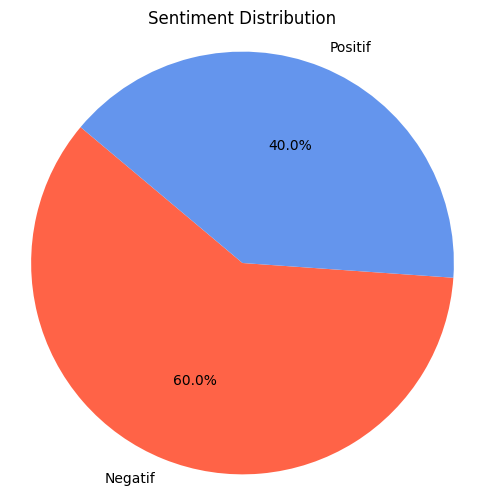

In [8]:

# Mengambil frekuensi label sentimen
vader_counts = df['Sentiment_Label'].value_counts()

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(vader_counts, labels=vader_counts.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'cornflowerblue'])
plt.title('Sentiment Distribution')
plt.axis('equal')  # Memastikan lingkaran terlihat proporsional
plt.show()


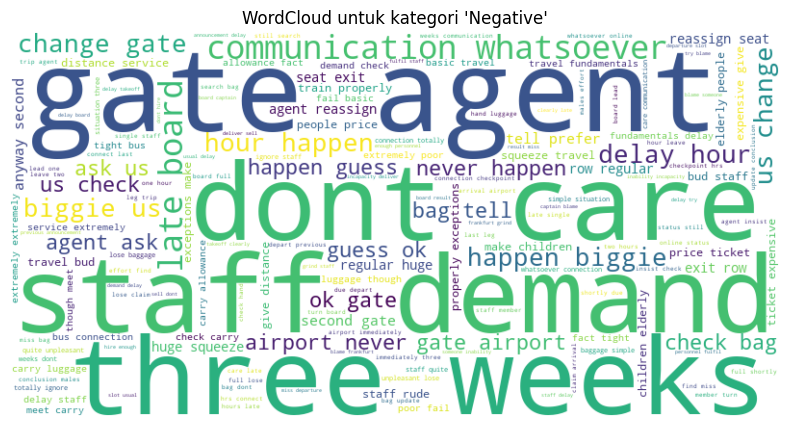

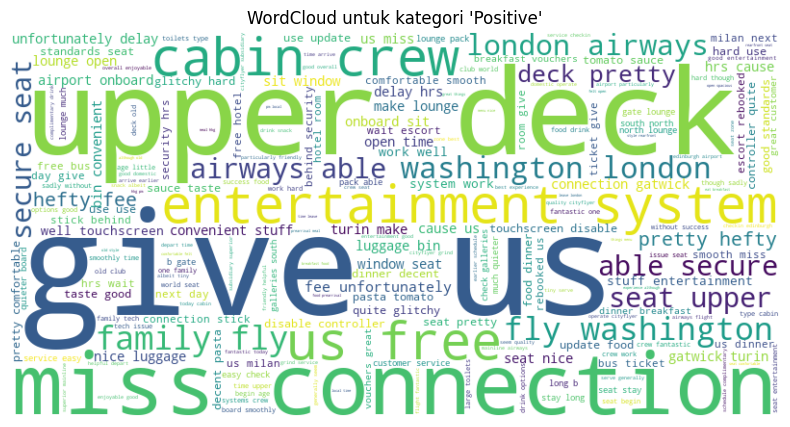

In [9]:
# Fungsi untuk membuat WordCloud
def generate_wordcloud(text, category):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud untuk kategori '{category}'")
    plt.axis('off')
    plt.show()

# Ambil data untuk masing-masing kategori
Negatif_reviews = df[df['Sentiment_Label'] == 'Negatif']['Reviews_processed']
#Netral_reviews = df[df['Sentiment_Label'] == 'Netral']['Reviews_processed']
Positif_reviews = df[df['Sentiment_Label'] == 'Positif']['Reviews_processed']

# Gabungkan teks masing-masing kategori menjadi satu string
Negatif_text = ' '.join(Negatif_reviews)
#Netral_text = ' '.join(Netral_reviews)
Positif_text = ' '.join(Positif_reviews)

# Membuat WordCloud untuk masing-masing kategori
generate_wordcloud(Negatif_text, "Negative")
#generate_wordcloud(Netral_text, "Netral")
generate_wordcloud(Positif_text, "Positive")

In [10]:
!pip install gensim


## Creating Bigram, Trigram Models, Dictionary, Corpus

In [11]:
def preprocess_and_create_corpus(text_list, min_bigram_count=5, no_below=5, no_above=0.2):
    # Add bigrams and trigrams to docs
    bigram = Phrases(text_list, min_count=min_bigram_count)
    trigram = Phrases(bigram[text_list])

    for idx in range(len(text_list)):
        for token in bigram[text_list[idx]]:
            if '_' in token:
                text_list[idx].append(token)
        for token in trigram[text_list[idx]]:
            if '_' in token:
                text_list[idx].append(token)

    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(text_list)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

    # Build TF-IDF model
    tfidf = models.TfidfModel(doc_term_matrix)
    corpus_tfidf = tfidf[doc_term_matrix]

    return dictionary, corpus_tfidf

In [12]:
# split text in content_process into word
text = df['Reviews_processed']
text_list =  [i.split() for i in text]
print(len(text_list))
print(text_list)

1000
[['family', 'fly', 'washington', 'london', 'airways', 'able', 'secure', 'seat', 'upper', 'deck', 'pretty', 'hefty', 'fee', 'unfortunately', 'delay', 'hrs', 'cause', 'us', 'miss', 'connection', 'gatwick', 'turin', 'make', 'lounge', 'open', 'time', 'get', 'airport', 'onboard', 'sit', 'window', 'seat', 'nice', 'luggage', 'bin', 'convenient', 'stuff', 'entertainment', 'system', '’', 'work', 'well', 'touchscreen', 'disable', 'controller', 'quite', 'glitchy', 'hard', 'use', 'use', 'update', 'food', 'dinner', 'decent', 'pasta', 'tomato', 'sauce', 'taste', 'good', 'standards', 'seat', 'pretty', 'comfortable', 'smooth', 'miss', 'connection', '’', 'stick', 'behind', 'security', 'hrs', 'wait', 'escort', 'rebooked', 'us', 'milan', 'next', 'day', 'give', 'us', 'free', 'bus', 'ticket', 'give', 'us', 'free', 'hotel', 'room', 'give', 'us', 'dinner', 'breakfast', 'vouchers', 'great', 'customer', 'service'], ['easy', 'check', 'galleries', 'south', 'north', 'lounge', 'pack', 'able', 'get', 'seat', '

In [13]:
#call the function
dictionary, corpus_tfidf = preprocess_and_create_corpus(text_list)

## Coherence Scores

In [14]:
# coherence score
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step, passes, iterations, random_state=42):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,random_state=42, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

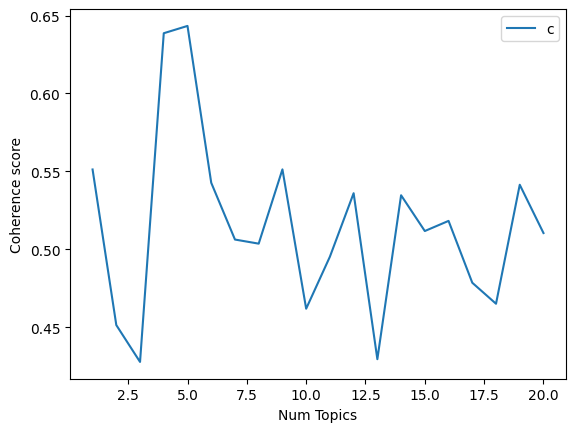

In [15]:
# call the function
start=1
limit=21
step=1
model_list, coherence_values = compute_coherence_values(dictionary,
                                                        corpus=corpus_tfidf,
                                                        texts=text_list,
                                                        start=start,
                                                        limit=limit,
                                                        step=step,
                                                        passes=10000,
                                                        iterations=10000,
                                                        random_state=42)
#show graphs
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6))

Num Topics = 1  has Coherence Value of 0.551213
Num Topics = 2  has Coherence Value of 0.451362
Num Topics = 3  has Coherence Value of 0.427719
Num Topics = 4  has Coherence Value of 0.638652
Num Topics = 5  has Coherence Value of 0.643337
Num Topics = 6  has Coherence Value of 0.542679
Num Topics = 7  has Coherence Value of 0.506249
Num Topics = 8  has Coherence Value of 0.503617
Num Topics = 9  has Coherence Value of 0.551277
Num Topics = 10  has Coherence Value of 0.461868
Num Topics = 11  has Coherence Value of 0.495245
Num Topics = 12  has Coherence Value of 0.535985
Num Topics = 13  has Coherence Value of 0.429473
Num Topics = 14  has Coherence Value of 0.534669
Num Topics = 15  has Coherence Value of 0.511713
Num Topics = 16  has Coherence Value of 0.518221
Num Topics = 17  has Coherence Value of 0.478524
Num Topics = 18  has Coherence Value of 0.465054
Num Topics = 19  has Coherence Value of 0.541411
Num Topics = 20  has Coherence Value of 0.510417


# Filter topic

In [17]:
# Mengurutkan Coherence Scores dalam urutan menurun
sorted_coherence_values = sorted(enumerate(coherence_values, start=start), key=lambda x: x[1], reverse=True)

# Mengambil 3 nilai tertinggi
top_3_topics = sorted_coherence_values[:3]

# Menampilkan topik berdasarkan nilai Coherence Score tertinggi
for idx, cv in top_3_topics:
    print("Num Topics =", idx, " has Coherence Value of", round(cv, 6))

# Menampilkan kata-kata kunci dari topik teratas
for idx, _ in top_3_topics:
    top_topic = model_list[idx - start]  # model_list dimulai dari indeks 0, sedangkan num_topics dimulai dari start
    top_topic_words = top_topic.show_topics(num_topics=1, num_words=10, formatted=False)
    print("Topik #{} Kata-kata Kunci: {}".format(idx, ", ".join([word for word, _ in top_topic_words[0][1]])))


Num Topics = 5  has Coherence Value of 0.643337
Num Topics = 4  has Coherence Value of 0.638652
Num Topics = 9  has Coherence Value of 0.551277
Topik #5 Kata-kata Kunci: extremely, carry, children, price, distance, elderly, rude, train, poor, expensive
Topik #4 Kata-kata Kunci: late, board, cityflyer, dont, blame, hire, incapacity, demand, inability, deliver
Topik #9 Kata-kata Kunci: late, board, dont, cityflyer, blame, communication, three, lose, care, whatsoever


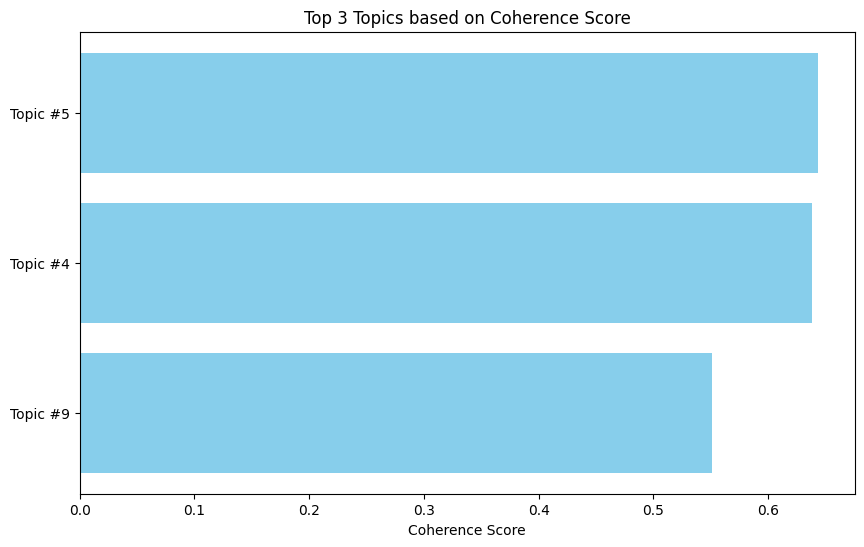

In [18]:
# Daftar nilai Coherence Score untuk top 3 topik teratas
coherence_scores = [cv for idx, cv in top_3_topics]
topic_labels = [f"Topic #{idx}" for idx, _ in top_3_topics]

# Membuat bar chart untuk Coherence Scores
plt.figure(figsize=(10, 6))
plt.barh(topic_labels, coherence_scores, color='skyblue')
plt.xlabel('Coherence Score')
plt.title('Top 3 Topics based on Coherence Score')
plt.gca().invert_yaxis()  # Membalik urutan topik agar yang tertinggi ada di atas
plt.show()

Berdasarkan kata-kata kunci tersebut, berikut adalah judul untuk masing-masing topik:

1. **Topik #5: "Customer Service and Experience"**
   - Kata-kata kunci: extremely, carry, children, price, distance, elderly, rude, train, poor, expensive
   - Judul ini mungkin sesuai dengan kata-kata kunci yang mencakup pengalaman pelanggan, layanan, harga tiket, dan interaksi dengan staf.

2. **Topik #4: "Flight Delays and Issues"**
   - Kata-kata kunci: late, board, cityflyer, dont, blame, hire, incapacity, demand, inability, deliver
   - Judul ini bisa mencerminkan kata-kata kunci yang terkait dengan keterlambatan penerbangan, masalah di bandara, dan ketidakmampuan untuk memberikan layanan yang tepat waktu.

3. **Topik #9: "Communication and Service Quality"**
   - Kata-kata kunci: late, board, dont, cityflyer, blame, communication, three, lose, care, whatsoever
   - Judul ini dapat mencerminkan masalah komunikasi, pelayanan, dan ketidakpuasan terkait dengan layanan maskapai.



# Create Own Model

In [19]:
df0 = df.copy()


In [20]:
df0

,Reviews,Reviews_processed,Sentiment,Sentiment_Label
0,My family flew from Washington to London on a ...,family fly washington london airways able secu...,0.9803,Positif
1,Easy check in a T5. Galleries south and North ...,easy check galleries south north lounge pack a...,0.9415,Positif
2,"Flight delayed by an hour, it happens, no bigg...",delay hour happen biggie us change gate airpor...,-0.2235,Negatif
3,The staff are very rude and not trained proper...,staff rude not train properly exceptions make ...,-0.7698,Negatif
4,Good domestic flight operated by BA Cityflyer....,good domestic operate cityflyer grind service ...,0.9420,Positif
...,...,...,...,...
995,Failed at all basic travel fundamentals: 1) Ou...,fail basic travel fundamentals delay staff dem...,-0.9097,Negatif
996,They lost my baggage in a very simple situatio...,lose baggage simple situation three weeks dont...,-0.7939,Negatif
997,Late boarding led to a one hour flight leaving...,late board lead one hour leave two hours late ...,-0.6249,Negatif
998,As usual the flight is delayed. BA try to blam...,usual delay try blame someone inability incapa...,-0.7845,Negatif


In [21]:
# Mengubah target dari string ke numeric

label_encoder = LabelEncoder()
df0['class'] = label_encoder.fit_transform(df0['Sentiment_Label'])
df0

,Reviews,Reviews_processed,Sentiment,Sentiment_Label,class
0,My family flew from Washington to London on a ...,family fly washington london airways able secu...,0.9803,Positif,1
1,Easy check in a T5. Galleries south and North ...,easy check galleries south north lounge pack a...,0.9415,Positif,1
2,"Flight delayed by an hour, it happens, no bigg...",delay hour happen biggie us change gate airpor...,-0.2235,Negatif,0
3,The staff are very rude and not trained proper...,staff rude not train properly exceptions make ...,-0.7698,Negatif,0
4,Good domestic flight operated by BA Cityflyer....,good domestic operate cityflyer grind service ...,0.9420,Positif,1
...,...,...,...,...,...
995,Failed at all basic travel fundamentals: 1) Ou...,fail basic travel fundamentals delay staff dem...,-0.9097,Negatif,0
996,They lost my baggage in a very simple situatio...,lose baggage simple situation three weeks dont...,-0.7939,Negatif,0
997,Late boarding led to a one hour flight leaving...,late board lead one hour leave two hours late ...,-0.6249,Negatif,0
998,As usual the flight is delayed. BA try to blam...,usual delay try blame someone inability incapa...,-0.7845,Negatif,0


In [22]:
# Get Label Name
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

{'Negatif': 0, 'Positif': 1}


In [23]:
# Split antara X dan y

X = df0['Reviews_processed'].to_numpy() # features
y = df0['class'].to_numpy() # target

In [24]:
# Split between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=10)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (640,)
Val Size :  (160,)
Test Size :  (200,)


In [25]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_val_vec = Vectorize.transform(X_val)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<640x304 sparse matrix of type '<class 'numpy.int64'>'
	with 25019 stored elements in Compressed Sparse Row format>

In [26]:
# Mencari Jumlah Vocab dan Panjang Token dalam Satu Document

jml_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", jml_vocab)
print("Panjang maksimum kalimat : ", max_sen_len, "kata")

Jumlah vocab :  304
Panjang maksimum kalimat :  96 kata


In [27]:
# Mengubah Target ke dalam One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [28]:
# Tensorflow pipeline


train_pipe = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe)).batch(20)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe)).batch(20)

In [29]:

text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

In [30]:
# Embedding Layer

embedding_baseline = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [31]:
text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'seat',
 'us',
 'delay',
 'staff',
 'board',
 'miss',
 'connection',
 'give',
 'airport',
 'check',
 'good',
 'time',
 'entertainment',
 'food',
 'not',
 'gate',
 'crew',
 'late']

In [32]:
# Clear Session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [33]:


model_imp1 = Sequential()

# Layer Text Vectorization
model_imp1.add(text_vectorization)

# Layer Embedding
model_imp1.add(embedding_baseline)

# Hidden Layer 1
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Hidden Layer 2
model_imp1.add(tf.keras.layers.Bidirectional(LSTM(64, kernel_initializer=tf.keras.initializers.HeNormal(seed))))

# Layer Output
model_imp1.add(Dense(2, activation='softmax'))

# Compile
model_imp1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
model_imp1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 96)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 96, 128)           38912     
                                                                 
 bidirectional (Bidirectiona  (None, 96, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                        

In [34]:
model_imp1_hist = model_imp1.fit(train_pipe, epochs=20, batch_size=20, validation_data=val_pipe)

Epoch 1/20
32/32 [==============================] - 15s 239ms/step - loss: 0.1782 - accuracy: 0.9109 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 2/20
32/32 [==============================] - 6s 179ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/20
32/32 [==============================] - 6s 178ms/step - loss: 8.5512e-04 - accuracy: 1.0000 - val_loss: 6.7909e-04 - val_accuracy: 1.0000
Epoch 4/20
32/32 [==============================] - 6s 177ms/step - loss: 5.2250e-04 - accuracy: 1.0000 - val_loss: 4.4886e-04 - val_accuracy: 1.0000
Epoch 5/20
32/32 [==============================] - 6s 182ms/step - loss: 3.5705e-04 - accuracy: 1.0000 - val_loss: 3.1808e-04 - val_accuracy: 1.0000
Epoch 6/20
32/32 [==============================] - 6s 186ms/step - loss: 2.5864e-04 - accuracy: 1.0000 - val_loss: 2.3543e-04 - val_accuracy: 1.0000
Epoch 7/20
32/32 [==============================] - 6s 186ms/step - loss: 1.9306e-04 - accuracy: 1.0000 - val_loss:

In [35]:
# Create DataFrame

history_imp1_df = pd.DataFrame(model_imp1_hist.history)
history_imp1_df

,loss,accuracy,val_loss,val_accuracy
0,0.178221,0.910937,0.004924,1.0
1,0.002245,1.000000,0.001230,1.0
2,0.000855,1.000000,0.000679,1.0
3,0.000523,1.000000,0.000449,1.0
4,0.000357,1.000000,0.000318,1.0
5,0.000259,1.000000,0.000235,1.0
6,0.000193,1.000000,0.000170,1.0
7,0.000127,1.000000,0.000113,1.0
8,0.000100,1.000000,0.000095,1.0
9,0.000085,1.000000,0.000081,1.0


<Axes: >

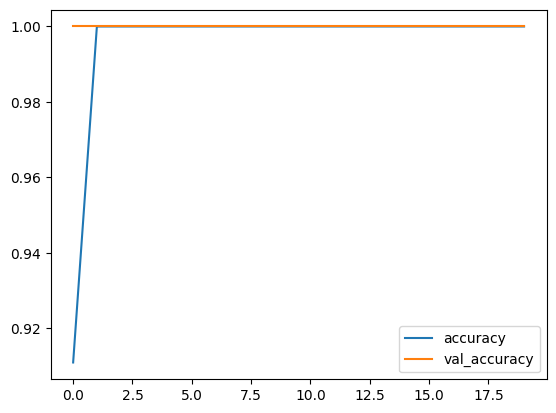

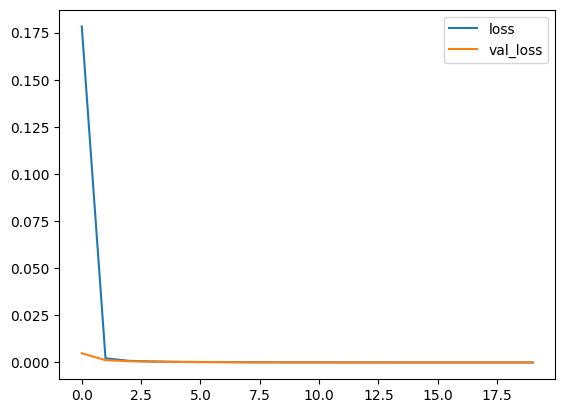

In [36]:
# Plot

history_imp1_df[['accuracy', 'val_accuracy']].plot()
history_imp1_df[['loss', 'val_loss']].plot()

In [37]:
y_pred_improve = model_imp1.predict(X_test)
y_pred_improve = np.argmax(y_pred_improve, axis=1)

print(classification_report(y_test, y_pred_improve))

7/7 [==============================] - 2s 68ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00        86

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [38]:
# Pembuatan DF Act vs Pred
act_pred_imp1 = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_improve)
})
df_act_pred_imp1 = pd.concat([pd.DataFrame(X_test), act_pred_imp1],axis=1)
df_act_pred_imp1 

,0,actual,prediction
0,easy check galleries south north lounge pack a...,1,1
1,lose baggage simple situation three weeks dont...,0,0
2,good domestic operate cityflyer grind service ...,1,1
3,staff rude not train properly exceptions make ...,0,0
4,fantastic today cabin crew seat zone best expe...,1,1
...,...,...,...
195,good domestic operate cityflyer grind service ...,1,1
196,delay hour happen biggie us change gate airpor...,0,0
197,usual delay try blame someone inability incapa...,0,0
198,family fly washington london airways able secu...,1,1


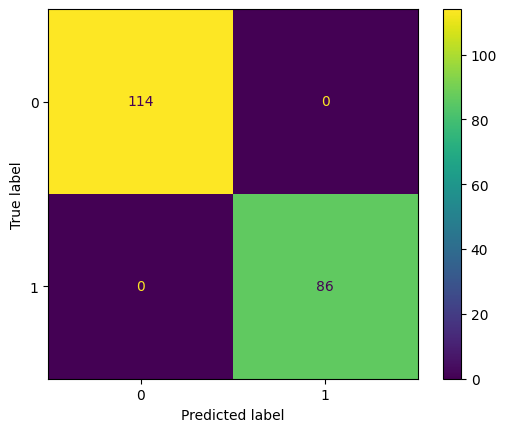

In [39]:
# Confusion Matrix
cm_test_imp1 = confusion_matrix(y_test, y_pred_improve)
ConfusionMatrixDisplay(cm_test_imp1).plot()